# Aerial images preprocessing with fiducial markers

The aerial preprocessing is highly inspired of [friedrichknuth/hipp](https://github.com/friedrichknuth/hipp) and this notebook use the same dataset as the [image restitution notebook](https://github.com/friedrichknuth/hipp/blob/master/examples/image_restitution/notebook.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os

## Downloading the dataset

The dataset consists of 41 images of the South Cascade Glacier acquired on September 6, 1994.
The total download size is approximately 17 GB, but after GDAL optimization, the entire dataset occupies only around 9 GB on disk.

In [3]:
images_metadata = "data/aerial/1994_06_09_aerial_scg.csv"
raw_images_directory = "data/aerial/raw_images"

if not os.path.exists(raw_images_directory):
    hipp.dataquery.NAGAP_download_images_to_disk(images_metadata, raw_images_directory)

# generate quick views of tif images with 20% resolution in .jpg
hipp.tools.generate_quickviews(raw_images_directory, factor=0.2, max_workers=8)

Downloading:   0%|          | 0/41 [00:00<?, ?file/s]

Generating quickviews: 100%|██████████| 41/41 [00:09<00:00,  4.14image/s]


## Path settings

In [6]:
raw_images_directory = "data/aerial/raw_images"
output_directory = "data/aerial/preprocessed_images"
fiducial_templates_directory = "data/aerial/fiducial_templates"
qc_directory = "data/aerial/qc"

# create the AerialPreprocessing class instance for the preprocessing 
ap = hipp.AerialPreprocessing(raw_images_directory, output_directory, fiducial_templates_directory, qc_directory)

## Step 1 : Creation of midside fiducial template

- Choose an example image from the downloaded set (by default the first image will be used)
- `AerialPreprocessing.create_fiducial_template()`
    - will launch an `opencv2` window to interactively select the midside fiducial marker center (with `Ctrl + Click`).
    - will enhance the resolution of the template for matching at subpixel accuracy.
    - will launch an other `opencv2` window of the enhanced template to select the exact center of the fiducial. The matching routine implemented below first performs a coarse template matching, then refines the position using the subpixel template.

**Note** :
For reproducibility, `AerialPreprocessing.create_fiducial_template()` returns:
- The coarse coordinate of the fiducial.
- The subpixel-refined coordinate of the fiducial center.

If you already have these coordinates (e.g., saved from a previous run), you can pass them to the function to skip manual clicks entirely.


In [7]:
saved_coords_midside = {'fiducial_coordinate': (1040, 5881), 'subpixel_center_coordinate': (803, 803)}

_ = ap.create_fiducial_template(midside=True, **saved_coords_midside)

## Step 2 : Creation of corner fiducial template

repeat the same steps above for corner fiducials.

In [8]:
saved_coords_corner = {'fiducial_coordinate': (1115, 381), 'subpixel_center_coordinate': (805, 803)}

_ = ap.create_fiducial_template(corner=True, **saved_coords_corner)

Before starting the next step make sure to have correct fiducials templates.

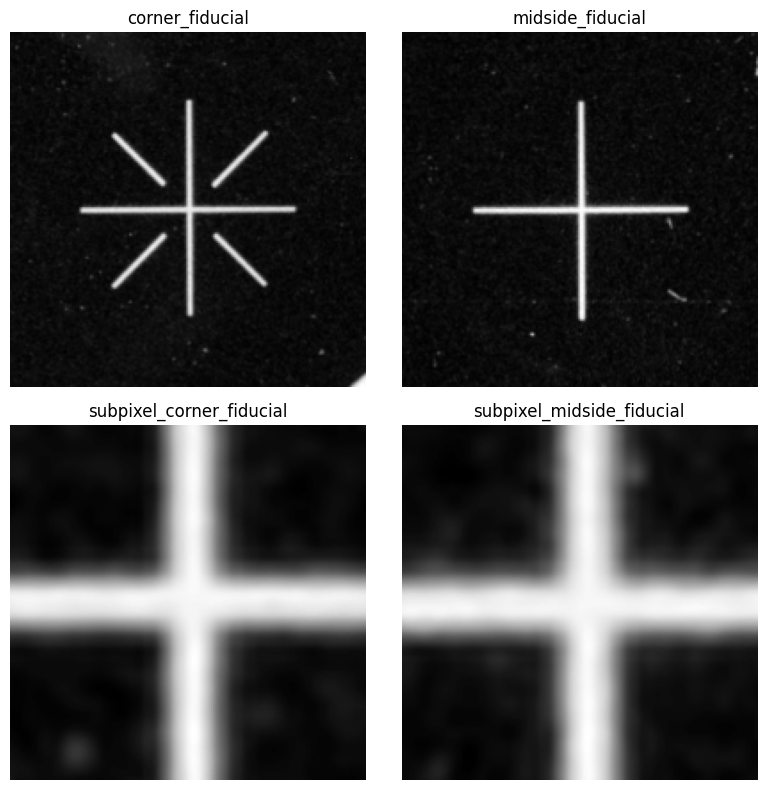

In [ ]:
ap.plot_fiducial_templates()

## Step 3 : fiducials detection

The `AerialPreprocessing.detect_fiducials()` method will detect for all images in the raw images directory, midside fiducials and/or corner fiducials. The method will also save so qc plot to control detections. To work, the method will call for each raw image the function `hipp.aerial.core.detect_fiducials` wich perform the following steps:
- grid the image into a n x n blocks (where n is the parameters `grid_size`).
- if both corner_fiducial and supixel_corner_fiducial exists:
    - perform coarse template matching on the 4 corner blocks
    - refine the position using the supixel_corner_fiducial
- if both midside_fiducial and supixel_midside_fiducial exists:
    - perform coarse template matching on the 4 midside blocks
    - refine the position using the supixel_corner_fiducial
- compute principal point using all detected fiducials

**Note** : 
- this method use multi-threading
- the `grid_size` need to be an **odd number**, and should be chosen such that all fiducials fall within the expected grid layout for accurate detection.

/home/godinlu/.local/share/hatch/env/virtual/hipp/6cXfZaze/dev/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Fiducials detection: 100%|██████████| 41/41 [00:16<00:00,  2.51it/s]


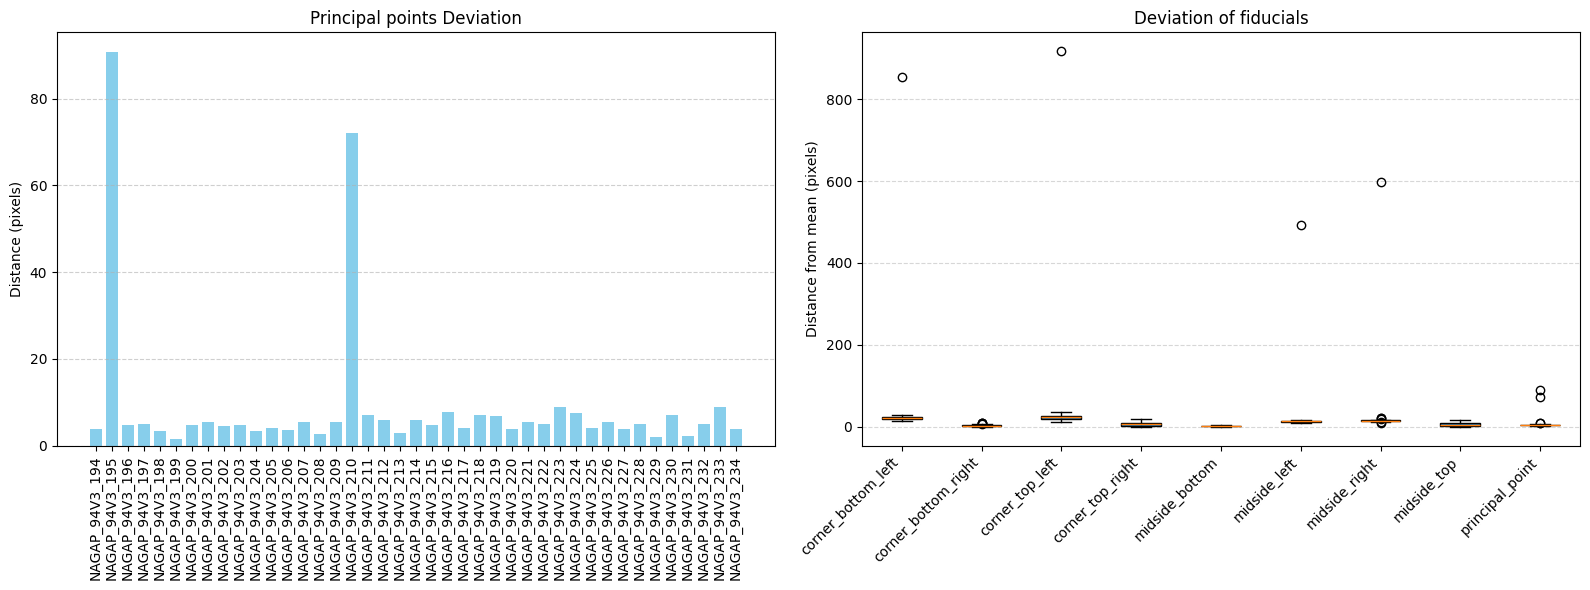

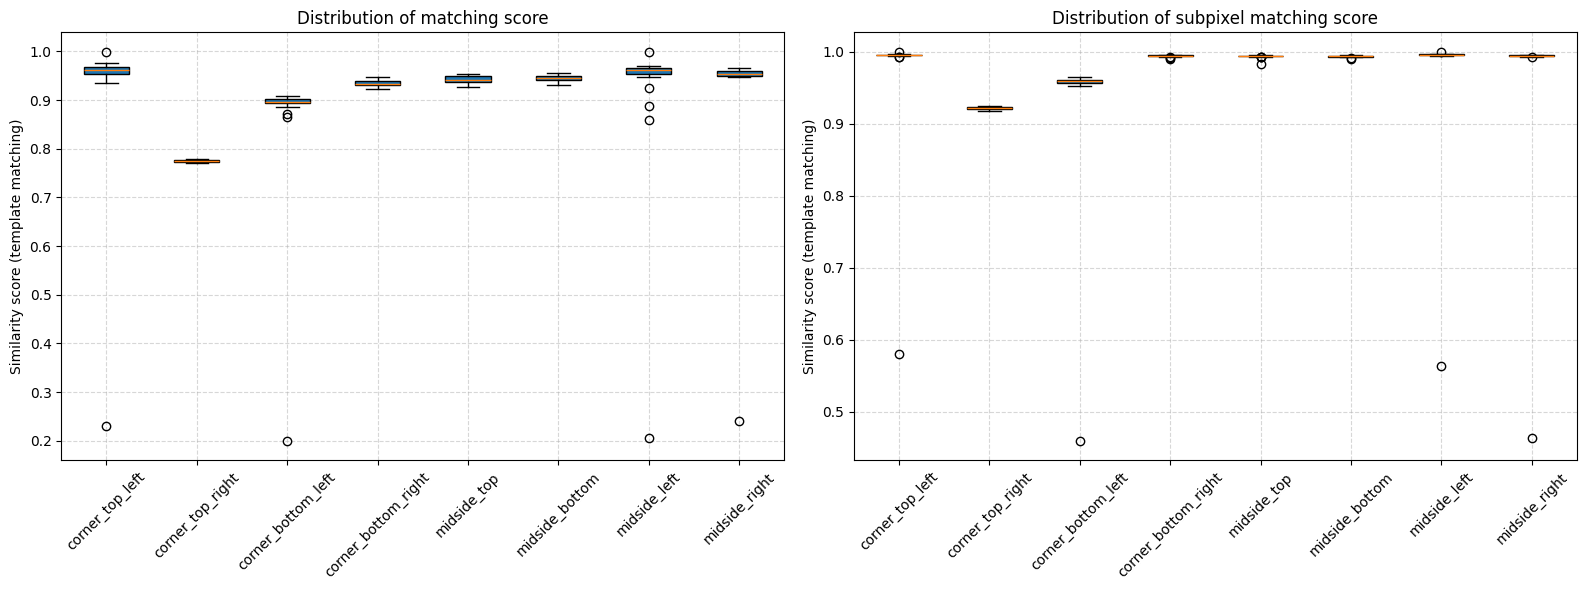

In [10]:
all_detections, all_scores, all_subpixel_scores = ap.detect_fiducials(grid_size=7, max_workers=5)

as we can see on thoses qc plots the detection seems to be correct cause the distributions of matching score are close from 1. But we observe also 2 outliers with the principal points deviation plot. That can be cause of some miss detection caused by noise on images. You can check what are been detected for the outliers by looking the individuals qc plots for our two images:
- [NAGAP_94V3_195](data/aerial/qc/fiducials_detection/individuals/NAGAP_94V3_195.png)
- [NAGAP_94V3_210](data/aerial/qc/fiducials_detection/individuals/NAGAP_94V3_210.png)

## Step 4 : Outlier removal

Filters out false positives based on two criteria:

- **Geometric Consistency:** Calculates angles between fiducials, validating those close to 90°, assuming a square fiducial pattern.
- **Matching Score Thresholding:** Compares the score of each match to the median score and keeps only those with a certain threshold 

After filtering:
- The principal point is recalculated using valid diagonal and adjacent fiducials.
- For adjacent fiducials: the midpoint of the segment is computed, and a perpendicular offset is applied based on half the segment length.
- For diagonal fiducials: the midpoint of the segment is used directly.

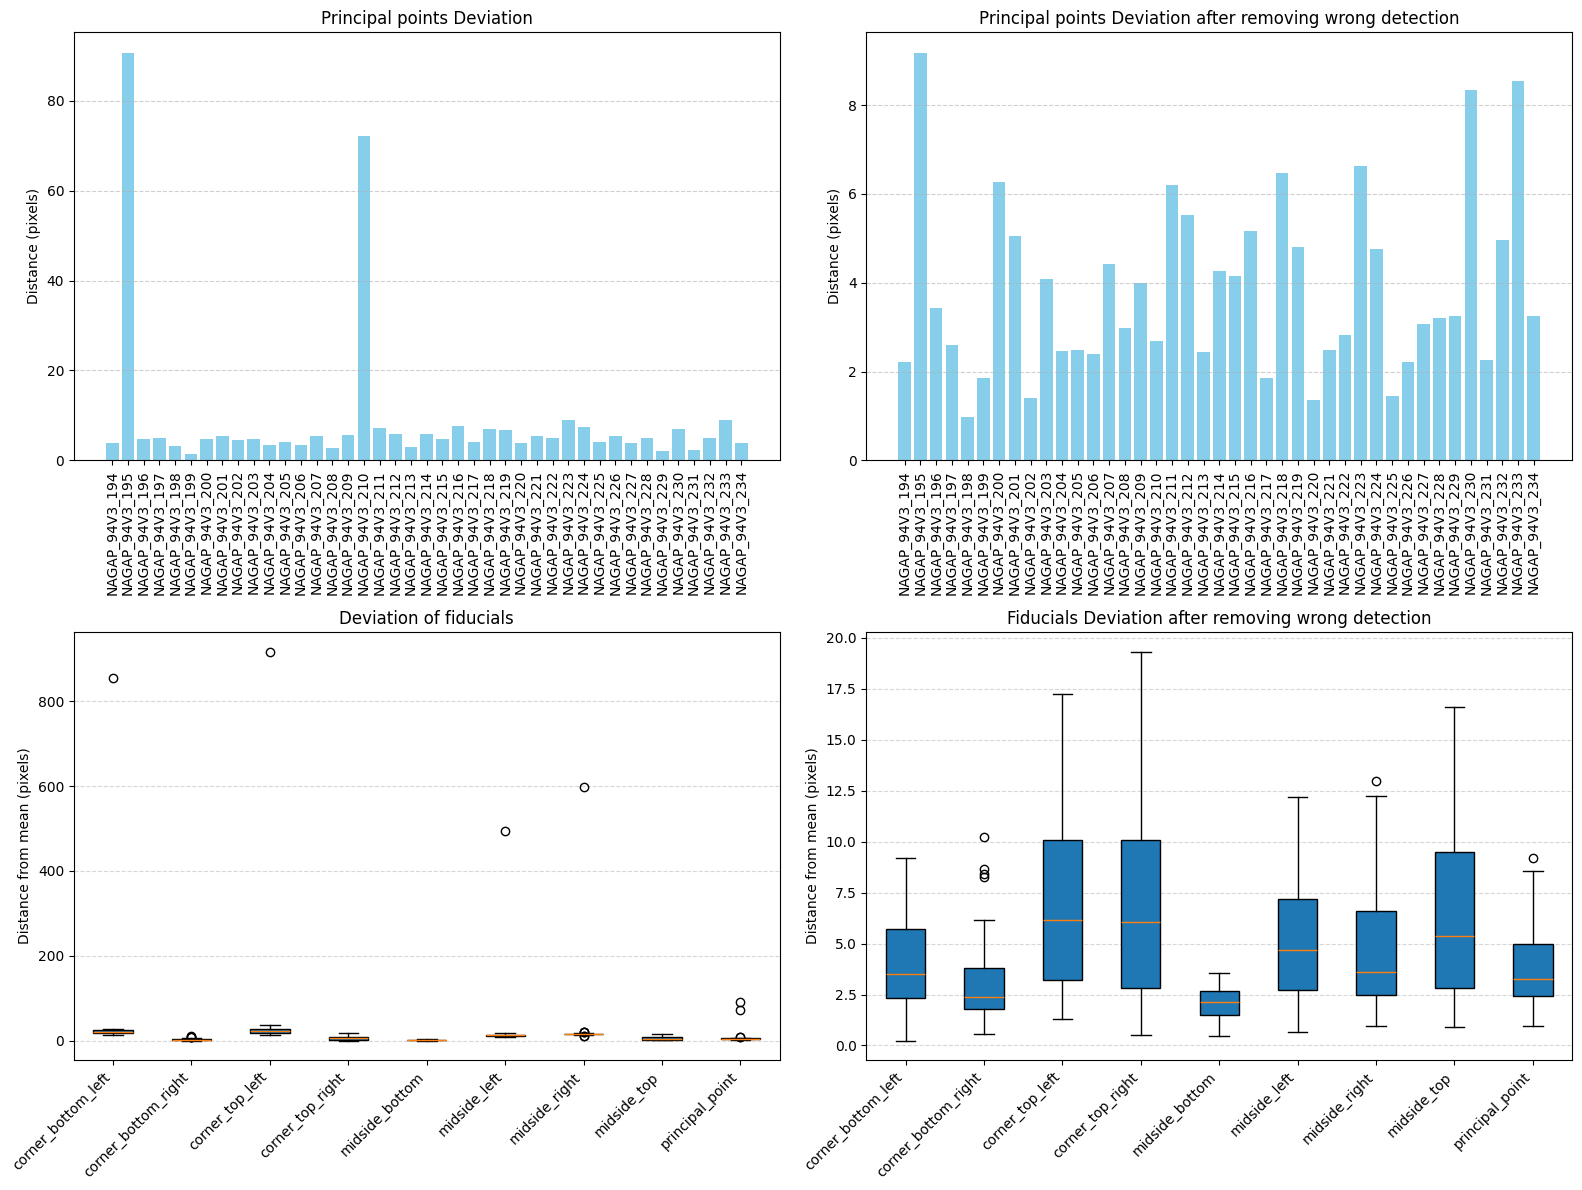

In [13]:
filtered_detections = ap.filter_detected_fiducials(all_detections, all_scores, all_subpixel_scores)

# we can save the detections in a csv file if we want
hipp.aerial.detected_fiducials_to_csv(filtered_detections, os.path.join(raw_images_directory, "detected_fiducial_markers.csv"))

As we can see on those qc plots, outliers seems to be correctly removed and we now have a decent deviation beetween detected fiducials coordinates.

## Step 6 : Prepare calibrated (true) fiducial marker coordinates

- Extract calibrated fiducial marker coordinate information from [calibration report](data/aerial/calibration_report.pdf), obtained via entering Camera Number, Lens Number, and Focal Length (printed on image frame) at https://fsapps.nwcg.gov/afm/cam/cam.php
- Extract scanning resolution


In [14]:
true_fiducials_mm = {
    "corner_bottom_left": (-109.990, -110.002), # 1
    "corner_top_right": (110.010, 109.999), # 2
    "corner_top_left": (-109.989, 109.9995), # 3
    "corner_bottom_right": (109.998, -110.002), # 4
    "midside_left": (-111.998, -0.004), # 5
    "midside_right": (112.004, 0.000), # 6
    "midside_top": (-0.014, 111.993), # 7
    "midside_bottom": (0.000, -112.002) # 8
}
scanning_resolution_mm = 0.02

## Step 7 : Image restitution

The `AerialPreprocessing.images_restitution` method will preprocess all images in the raw image directory. It also generate a qc plot of the RMSE of the coordinate between true fiducials and detected fiducials before and after the transformation. To work, this method will call for each images the function `hipp.aerial.core.image_restitution` wich will peforms the following steps:
- convert the `true_fiducials_mm` in pixels ( / scanning_resolution_mm)
- translate `true_fiducials_pixels` with the computed principal point
- compute the appropriate geometric transformation to align true fiducials with detected fiducials based on the number of valid detected fiducials:
    - 1 point: Translation
    - 2 points: Similarity transformation
    - 3 or more points: Affine transformation
- transform the image with the computed transformation matrix and crop it with `image_square_dim`.
- Apply CLAHE enhancement

**Note** :
- The transformation matrix returned include the cropping. So if you apply those matrixs on detected fiducials coordinates, you will obtain detected fiducials coordinates of the final image.
- If `true_fiducials_mm` is `None` the first transformation is skipped.
- If `image_square_dim` is `None` the crop is skipped.
- This method use multi-processing to be faster.


Generating quickviews: 100%|██████████| 41/41 [00:02<00:00, 20.00image/s]


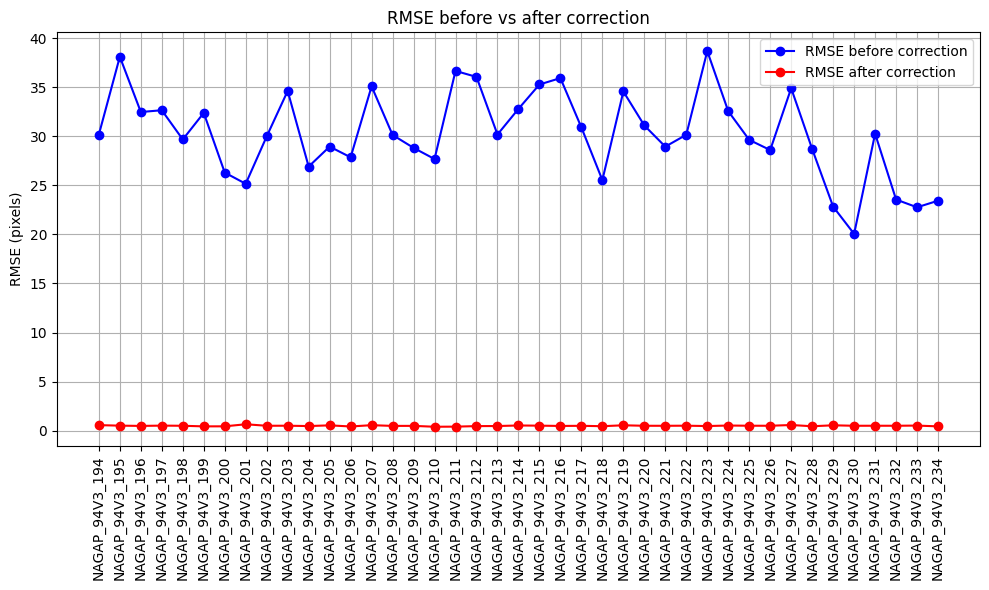

In [ ]:
transformation_matrixs = ap.images_restitution(
    filtered_detections,
    true_fiducials_mm,
    image_square_dim=10800, # this parameters can be calculated, if i want a 216 mm images then i convert in pixels with 216 / scanning_resolution_mm
    scanning_resolution_mm=scanning_resolution_mm,
    max_workers=8,
    dry_run=False
)

hipp.tools.generate_quickviews(output_directory, factor=0.2)

# apply previously computed transformation matrixs to detected fiducial coordinates, to
# have the detected fiducial coordinates of all restitute images.
transformed_detections = {k: v.transform(transformation_matrixs[k]) for k, v in filtered_detections.items()}
hipp.aerial.detected_fiducials_to_csv(transformed_detections, os.path.join(output_directory, "detected_fiducial_markers.csv"))